# Connect Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import LIB

In [2]:
!pip install transformers datasets sentencepiece sacremoses
!pip install --upgrade nltk
!pip install evaluate
!pip install datasets
!pip install accelerate
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
%env TORCH_USE_CUDA_DSA=1
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
from datasets import load_dataset
from torch.utils.data import DataLoader
from datetime import datetime
import nltk
from nltk.translate import meteor_score
from datasets import load_metric
from datasets import load_dataset
import pandas as pd
import json
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModelForSeq2SeqLM
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s et

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Datset

## Load dataset

In [3]:
dataset = load_dataset("ncduy/mt-en-vi")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2884451 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11316 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11225 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'vi', 'source'],
        num_rows: 2884451
    })
    validation: Dataset({
        features: ['en', 'vi', 'source'],
        num_rows: 11316
    })
    test: Dataset({
        features: ['en', 'vi', 'source'],
        num_rows: 11225
    })
})

## Train, Valid, Test

In [4]:
dataset_train = dataset["train"].select(range(80000))
dataset_valid = dataset["validation"]
dataset_test = dataset["test"]

## Tokenize Data

In [5]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-vi"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/756k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

In [6]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    model_inputs = tokenizer(
        batch['en'], max_length=max_input_length, truncation=True)

    # Set up the tokenizer for targets
    labels = tokenizer(
        text_target=batch['vi'], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [7]:
tokenized_datasets_train = dataset_train.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset_train.column_names,
)
tokenized_datasets_valid = dataset_valid.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset_valid.column_names,
)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11316 [00:00<?, ? examples/s]

In [8]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [9]:
batch = data_collator([tokenized_datasets_train[i] for i in range(0, 5)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [10]:
tokenizer.all_special_ids

[0, 1, 53684]

## Data Loader

In [11]:
train_loader = DataLoader(
    tokenized_datasets_train,
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_datasets_valid,
    batch_size=32,
    collate_fn=data_collator
)

In [12]:
tokenizer.add_special_tokens({"cls_token": "<s>"})

1

In [13]:
tokenizer.vocab_size

53685

# Transformer

## Positional Encoding

In [14]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
    super().__init__()
    # Dropout
    self.dropout = nn.Dropout(p=dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)

    # 10000^(2i/d_model)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))

    # Khởi tạo ma trận pos(max_len*d_model)
    pe = torch.zeros(1, max_len, d_model)

    # Positional Encoding
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:, :x.size(1), :]
    return self.dropout(x)

## Multi-head Attention

In [15]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
    super().__init__()

    self.d_k = d_k
    self.n_heads = n_heads

    # Create key, query, value
    self.key = nn.Linear(d_model, d_k * n_heads)
    self.query = nn.Linear(d_model, d_k * n_heads)
    self.value = nn.Linear(d_model, d_k * n_heads)

    self.fc = nn.Linear(d_k * n_heads, d_model)

    # Causual Mask
    self.causal = causal
    if causal:
      cm = torch.tril(torch.ones(max_len, max_len))
      self.register_buffer(
          "causal_mask",
          cm.view(1, 1, max_len, max_len)
      )

  def forward(self, q, k, v, pad_mask=None):
    q = self.query(q)
    k = self.key(k)
    v = self.value(v)

    N = q.shape[0]
    T_output = q.shape[1]
    T_input = k.shape[1]

    q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
    k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
    v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)

    # Attention score
    attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    if pad_mask is not None:
      attn_scores = attn_scores.masked_fill(
          pad_mask[:, None, None, :] == 0, float('-inf'))
    if self.causal:
      attn_scores = attn_scores.masked_fill(
          self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf'))
    attn_weights = F.softmax(attn_scores, dim=-1)

    A = attn_weights @ v

    A = A.transpose(1, 2)
    A = A.contiguous().view(N, T_output, self.d_k * self.n_heads)

    return self.fc(A)

## Encoder Block

In [16]:
class EncoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()
    # Layer AddNorm
    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    # Multi-head Attention
    self.mha = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    # Feed-forward
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    # Drop out
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, x, pad_mask=None):
    x = self.ln1(x + self.mha(x, x, x, pad_mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)
    return x

## Decode Block

In [17]:
class DecoderBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, max_len, dropout_prob=0.1):
    super().__init__()
    # Layer AddNorm
    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.ln3 = nn.LayerNorm(d_model)
    # Multi-head Attention Masked
    self.mha1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
    # Multi-head Attention
    self.mha2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
    # Feed-forward
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model),
        nn.Dropout(dropout_prob),
    )
    # Dropout
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    x = self.ln1(dec_input + self.mha1(dec_input, dec_input, dec_input, dec_mask))
    x = self.ln2(x + self.mha2(x, enc_output, enc_output, enc_mask))
    x = self.ln3(x + self.ann(x))
    x = self.dropout(x)
    return x

## Encoder

In [18]:
class Encoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
               dropout_prob):
    super().__init__()
    # Word embedding
    self.embedding = nn.Embedding(vocab_size, d_model)
    # Positional Encoding
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    # Multi encode-block
    transformer_blocks = [
        EncoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    # Layer Norm
    self.ln = nn.LayerNorm(d_model)

  def forward(self, x, pad_mask=None):
    x = self.embedding(x)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, pad_mask)
    x = self.ln(x)
    return x

## Decoder

In [19]:
class Decoder(nn.Module):
  def __init__(self,
               vocab_size,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
               dropout_prob):
    super().__init__()
    # Word Embedding
    self.embedding = nn.Embedding(vocab_size, d_model)
    # Positional Encoding
    self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
    # Multi-block Decode
    transformer_blocks = [
        DecoderBlock(
            d_k,
            d_model,
            n_heads,
            max_len,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    # Layer Norm
    self.ln = nn.LayerNorm(d_model)
    # Linear
    self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
    x = self.embedding(dec_input)
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(enc_output, x, enc_mask, dec_mask)
    x = self.ln(x)
    x = self.fc(x)
    return x

## Transformer

In [20]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_input, dec_input, enc_mask, dec_mask):
    enc_output = self.encoder(enc_input, enc_mask)
    dec_output = self.decoder(enc_output, dec_input, enc_mask, dec_mask)
    return dec_output

## Build Optimizer, Learning-Rate

Lớp ScheduledOptimizer này giúp thực hiện tối ưu hóa với tỷ lệ học tăng dần dựa trên số bước huấn luyện, điều này có thể hữu ích trong việc huấn luyện các mô hình sâu và phức tạp.

In [21]:
class ScheduledOptimizer():
    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0

    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }

        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']

        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## Training

In [22]:
encoder = Encoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=512,
                  n_heads=8,
                  n_layers=6,
                  dropout_prob=0.1)
decoder = Decoder(vocab_size=tokenizer.vocab_size + 1,
                  max_len=512,
                  d_k=16,
                  d_model=512,
                  n_heads=8,
                  n_layers=6,
                  dropout_prob=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)
transformer = Transformer(encoder, decoder)

cuda:0


In [23]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09)
optimizer = ScheduledOptimizer(optimizer,0.2, 64, 4000)

In [24]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for batch in train_loader:
      batch = {k: v.to(device) for k, v in batch.items()}

      optimizer.zero_grad()

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:, 0] = 53_685

      dec_input = dec_input.masked_fill(
          dec_input == -100, tokenizer.pad_token_id)

      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2, 1), targets)

      loss.backward()
      optimizer.step_and_update_lr()
      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for batch in valid_loader:
      batch = {k: v.to(device) for k, v in batch.items()}

      enc_input = batch['input_ids']
      enc_mask = batch['attention_mask']
      targets = batch['labels']

      dec_input = targets.clone().detach()
      dec_input = torch.roll(dec_input, shifts=1, dims=1)
      dec_input[:, 0] = 53_685

      dec_input = dec_input.masked_fill(dec_input == -100, tokenizer.pad_token_id)

      dec_mask = torch.ones_like(dec_input)
      dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)

      outputs = model(enc_input, dec_input, enc_mask, dec_mask)
      loss = criterion(outputs.transpose(2, 1), targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0

    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

    model_path = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/model_transformer.pth"
    optimizer_path = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/model_optimizer.pth"
    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)
  return train_losses, test_losses

### Train

In [ ]:
train_losses, test_losses = train(transformer, criterion, optimizer, train_loader, valid_loader, epochs=15)

Epoch 1/15, Train Loss: 6.3644,       Test Loss: 5.0661, Duration: 0:13:09.440625
Epoch 2/15, Train Loss: 4.8460,       Test Loss: 4.3989, Duration: 0:13:18.601632
Epoch 3/15, Train Loss: 4.2864,       Test Loss: 4.0150, Duration: 0:13:11.697905
Epoch 4/15, Train Loss: 3.9042,       Test Loss: 3.7197, Duration: 0:13:09.669215
Epoch 5/15, Train Loss: 3.6242,       Test Loss: 3.5257, Duration: 0:13:07.185515
Epoch 6/15, Train Loss: 3.4019,       Test Loss: 3.3917, Duration: 0:13:11.665174
Epoch 7/15, Train Loss: 3.2299,       Test Loss: 3.2987, Duration: 0:13:11.946464
Epoch 8/15, Train Loss: 3.0821,       Test Loss: 3.2352, Duration: 0:13:07.878953
Epoch 9/15, Train Loss: 2.9605,       Test Loss: 3.1958, Duration: 0:13:06.926142
Epoch 10/15, Train Loss: 2.8545,       Test Loss: 3.1717, Duration: 0:13:06.536981
Epoch 11/15, Train Loss: 2.7614,       Test Loss: 3.1293, Duration: 0:13:03.946725
Epoch 12/15, Train Loss: 2.6773,       Test Loss: 3.1111, Duration: 0:13:08.233166
Epoch 13/15, 

### Plot Loss

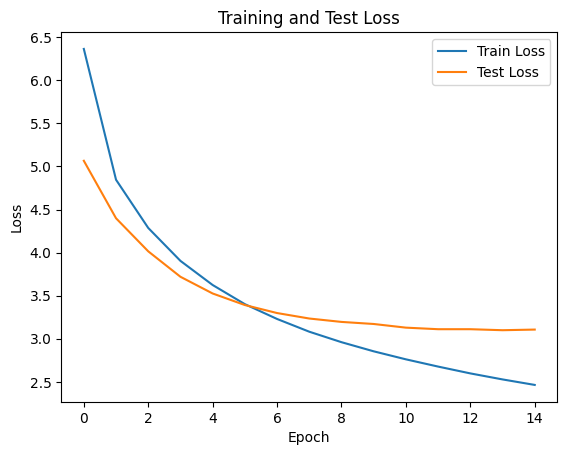

In [ ]:
def plot_loss(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, test_losses)

In [25]:
def load_model(model, optimizer, model_path, optimizer_path):
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))

model_path = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/model_transformer.pth"
optimizer_path = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/model_optimizer.pth"

load_model(transformer, optimizer, model_path, optimizer_path)

def translation_transformer(input_sentence, transformer):
    enc_input = tokenizer(input_sentence, return_tensors='pt').to(device)
    enc_output = transformer.encoder(enc_input['input_ids'], enc_input['attention_mask'])

    dec_input_ids = torch.tensor([[53_685]], device=device)
    dec_attn_mask = torch.ones_like(dec_input_ids, device=device)

    for _ in range(32):
      dec_output = transformer.decoder(
          enc_output,
          dec_input_ids,
          enc_input['attention_mask'],
          dec_attn_mask,
      )

      prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)
      dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))
      dec_attn_mask = torch.ones_like(dec_input_ids)

      if prediction_id == 0:
        break

    translation = tokenizer.decode(dec_input_ids[0, 1:-1])
    return translation

# T5

In [27]:
MODEL_NAME = "VietAI/envit5-base"
tokenizer_T5 = T5Tokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_T5, model=model)

spiece.model:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

In [28]:
def preprocess_function(examples):
   """Add prefix to the sentences, tokenize the text, and set the labels"""
   inputs = [doc for doc in examples["en"]]
   model_inputs = tokenizer_T5(inputs, max_length=128, truncation=True)

   labels = tokenizer_T5(text_target=examples["vi"],
                      max_length=128,
                      truncation=True)

   model_inputs["labels"] = labels["input_ids"]
   return model_inputs

In [29]:
tokenized_dataset_train = dataset_train.map(preprocess_function, batched=True)
tokenized_dataset_valid = dataset_valid.map(preprocess_function, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11316 [00:00<?, ? examples/s]

In [30]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/Model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_valid,
    tokenizer=tokenizer_T5,
    data_collator=data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# trainer.train()

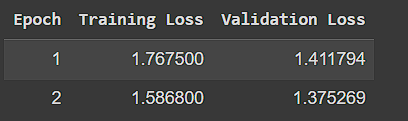

In [31]:
model_paths = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/Model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSeq2SeqLM.from_pretrained(model_paths).to(device)

def translation_T5(sentence):
    input_ids = tokenizer_T5.encode(sentence, return_tensors="pt").to(device)
    translated_text = model.generate(input_ids.to(device))
    translated_text_decoded = tokenizer_T5.decode(translated_text[0], skip_special_tokens=True)
    return translated_text_decoded

# Para of T5 vs Transformer

In [34]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Print number of parameters
print(f'Number of parameters in transformer: {count_parameters(transformer)}')
print(f'Number of parameters in T5: {count_parameters(model)}')

Number of parameters in transformer: 112479414
Number of parameters in T5: 275102976


# Test Transformer vs T5

In [ ]:
import warnings

In [ ]:
english_proverbs = [
    "A stitch in time saves nine.",
    "Actions speak louder than words.",
    "Don't count your chickens before they hatch.",
    "Every cloud has a silver lining.",
    "When in Rome, do as the Romans do."
]
for sentence in english_proverbs:
  print(f"Translate with transformer: {translation_transformer(sentence,transformer)}")
  print(f"Translate with T5: {translation_T5(sentence)}")
  print("*"*50)

Translate with transformer: Một lần nữa lưu giữ cho chín người.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Translate with T5: Một chút thời gian cứu chín người.
**************************************************
Translate with transformer: Các cuộc gọi khác thường hơn là nói.
Translate with T5: Hành động nói lên tiếng nói hơn là lời nói.
**************************************************
Translate with transformer: Đừng có đếma thuốc trước khi chúng bị cắt.
Translate with T5: Đừng đếm trứng gà trước khi chúng ra đời.
**************************************************
Translate with transformer: Những cái khăn có một cái đầu đạn tiền.
Translate with T5: Mỗi đám mây đều có một lớp kim cương.
**************************************************
Translate with transformer: Khi ở Rome, như là người La Mã.
Translate with T5: Khi ở Rome, làm như người La Mã làm.
**************************************************


# Evaluate

In [ ]:
def bleu_score(reference, candidate):
    N = min(4,len(candidate.split()))
    weights = tuple(1/N for i in range(N))
    bleu = nltk.translate.bleu_score.sentence_bleu(references=[reference.split()], hypothesis=candidate.split(), weights=weights)
    return bleu

def cal_meteor_score(reference, candidate):
    meteor = meteor_score.meteor_score([reference.split()], candidate.split())
    return meteor

In [ ]:
test_df = pd.DataFrame(dataset_test)

In [ ]:
test_df = test_df.drop(test_df.columns[2], axis=1)

In [ ]:
test_df['length'] = test_df['en'].apply(lambda x: len(x.split()))

In [ ]:
test_t5 = test_df.copy()
test_trans = test_df.copy()

## Transformer

In [ ]:
test_trans['translate'] = test_trans['en'].apply(lambda x: translation_transformer(x, transformer))

In [ ]:
test_trans['bleu_score'] = test_trans.apply(lambda row: bleu_score(row['vi'], row['translate']), axis=1)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
test_trans['meteor'] = test_trans.apply(lambda row: cal_meteor_score(row['vi'], row['translate']), axis=1)

In [ ]:
test_trans.to_csv('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/Output/transformer.csv', index=False)

## T5

In [ ]:
test_t5['translate'] = test_t5['en'].apply(lambda x: translation_T5(x))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
test_t5['bleu_score'] = test_t5.apply(lambda row: bleu_score(row['vi'], row['translate']), axis=1)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
test_t5['meteor'] = test_t5.apply(lambda row: cal_meteor_score(row['vi'], row['translate']), axis=1)

In [ ]:
test_t5.to_csv('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/Output/t5.csv', index=False)

## Visualize

In [ ]:
trans = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/Output/transformer.csv")
t5 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Final_2/Complete/Output/t5.csv")

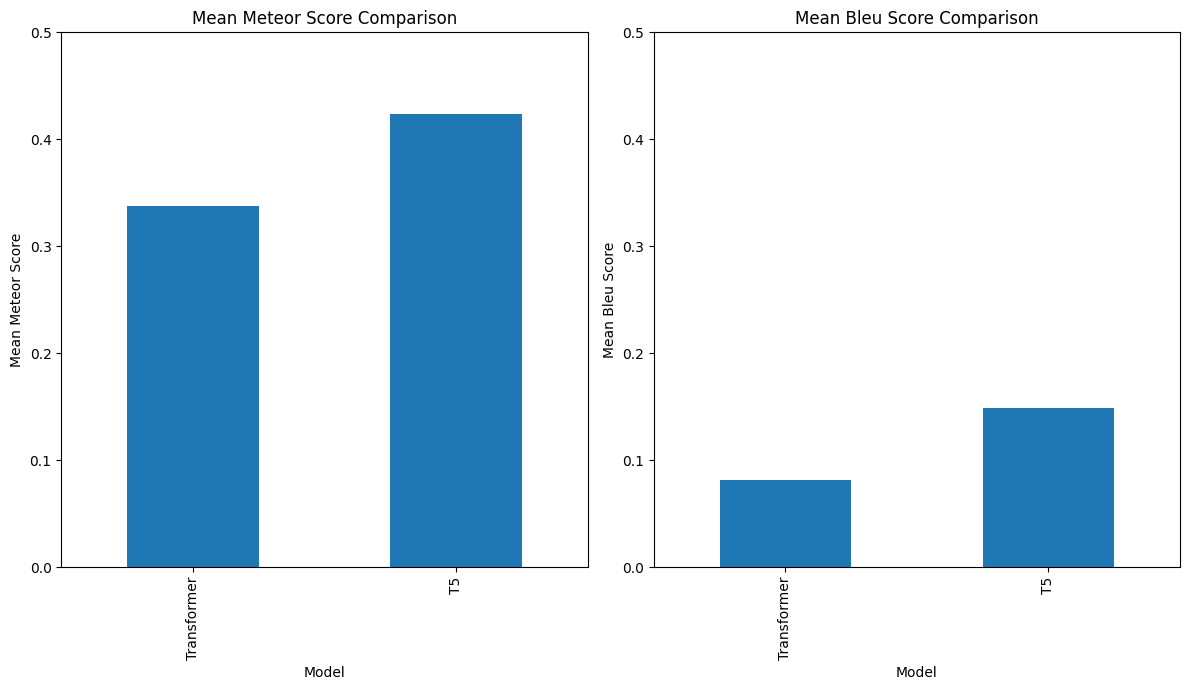

In [ ]:
# Tính giá trị trung bình của 'meteor' và 'bleu_score' cho từng tập dữ liệu
mean_meteor1 = trans['meteor'].mean()
mean_meteor2 = t5['meteor'].mean()
mean_bleu1 = trans['bleu_score'].mean()
mean_bleu2 = t5['bleu_score'].mean()

# Tạo DataFrame để lưu trữ giá trị trung bình
mean_scores = pd.DataFrame({
    'Model': ['Transformer', 'T5'],
    'Mean Meteor Score': [mean_meteor1, mean_meteor2],
    'Mean Bleu Score': [mean_bleu1, mean_bleu2]
})

# Tạo subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# Vẽ biểu đồ cho Mean Meteor Score
mean_scores.plot(kind='bar', x='Model', y='Mean Meteor Score', legend=False, ax=axs[0])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Mean Meteor Score')
axs[0].set_title('Mean Meteor Score Comparison')
axs[0].set_ylim(0, 0.5)  # Đặt giới hạn trục y từ 0 đến 0.5

# Vẽ biểu đồ cho Mean Bleu Score
mean_scores.plot(kind='bar', x='Model', y='Mean Bleu Score', legend=False, ax=axs[1])
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Mean Bleu Score')
axs[1].set_title('Mean Bleu Score Comparison')
axs[1].set_ylim(0, 0.5)  # Đặt giới hạn trục y từ 0 đến 0.5

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()

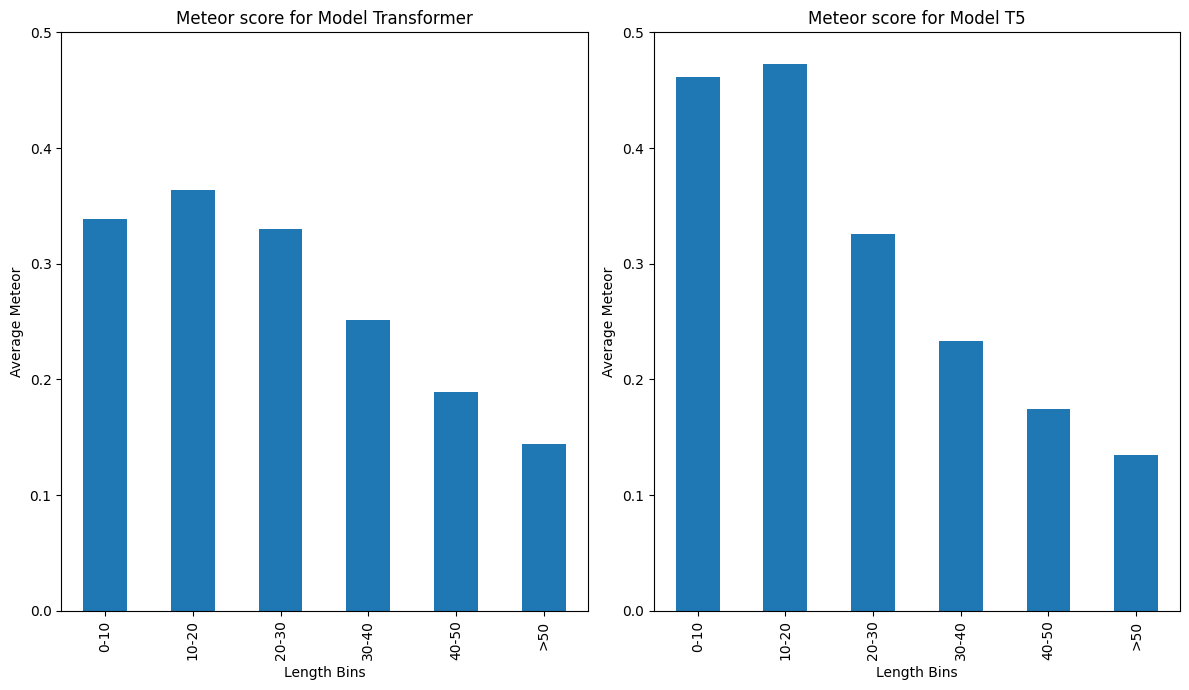

In [ ]:
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '>50']

trans['length_bin'] = pd.cut(trans['length'], bins=bins, labels=labels, right=False)
t5['length_bin'] = pd.cut(t5['length'], bins=bins, labels=labels, right=False)

# Tính giá trị trung bình của 'meteor' cho từng khoảng của 'length'
average_meteor1 = trans.groupby('length_bin')['meteor'].mean()
average_meteor2 = t5.groupby('length_bin')['meteor'].mean()

# Tạo subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# Vẽ biểu đồ cho tập dữ liệu 1
average_meteor1.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Length Bins')
axs[0].set_ylabel('Average Meteor')
axs[0].set_title('Meteor score for Model Transformer')
axs[0].set_ylim(0, 0.5)  # Đặt giới hạn trục y từ 0 đến 1

# Vẽ biểu đồ cho tập dữ liệu 2
average_meteor2.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Length Bins')
axs[1].set_ylabel('Average Meteor')
axs[1].set_title('Meteor score for Model T5')
axs[1].set_ylim(0, 0.5)  # Đặt giới hạn trục y từ 0 đến 1

plt.tight_layout()
plt.show()

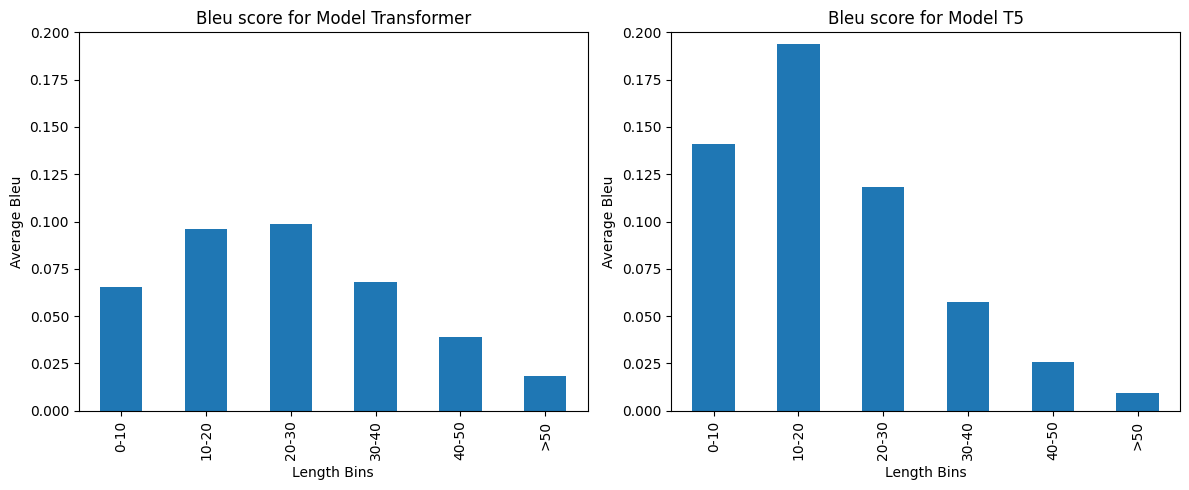

In [ ]:
bins = [0, 10, 20, 30, 40, 50, float('inf')]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '>50']

trans['length_bin'] = pd.cut(trans['length'], bins=bins, labels=labels, right=False)
t5['length_bin'] = pd.cut(t5['length'], bins=bins, labels=labels, right=False)

# Tính giá trị trung bình của 'meteor' cho từng khoảng của 'length'
average_bleu1 = trans.groupby('length_bin')['bleu_score'].mean()
average_bleu2 = t5.groupby('length_bin')['bleu_score'].mean()

# Tạo subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Vẽ biểu đồ cho tập dữ liệu 1
average_bleu1.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Length Bins')
axs[0].set_ylabel('Average Bleu')
axs[0].set_title('Bleu score for Model Transformer')
axs[0].set_ylim(0, 0.2)  # Đặt giới hạn trục y từ 0 đến 1

# Vẽ biểu đồ cho tập dữ liệu 2
average_bleu2.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Length Bins')
axs[1].set_ylabel('Average Bleu')
axs[1].set_title('Bleu score for Model T5')
axs[1].set_ylim(0, 0.2)

plt.tight_layout()
plt.show()